In [141]:
#importing libraries
import pandas as pd
import numpy as np 
%matplotlib inline
import seaborn as sns 
from matplotlib.patches import Patch
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.svm import SVC 
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

#%pip install --user yellowbrick
from yellowbrick.classifier import ClassificationReport
from yellowbrick.classifier import ConfusionMatrix

import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import metrics 
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.utils import class_weight
from sklearn.metrics import matthews_corrcoef
import seaborn as sns
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

In [142]:
#importing the data
df=pd.read_csv(r'C:\\Users\\strog\\Documents\\Google Dr Backup\\Google Dr Glasgow DA Master\\Final Project\\scripts\\subset_2class_agg.csv', 
                      sep=',')

In [143]:
#preparing imports - leaving only the significant variables chosen in EDA
df_X=df.drop(columns=['Num_Acc', 'severity', 'journey_reason', 'junction_type','secu_equipment', 'atmospheric_cond','traffic_type', 'acc_place_on_road', 'road_type',
                     'road_slope', 'surface_state'])


In [144]:
#getting list of categorical columns
var2=list(df_X.select_dtypes(include='object').columns)
#getting list of numerical columns
varn=list(df_X.select_dtypes(include='number').columns)

In [146]:
#formatting all categorical variables as strings
df_X[var2]=df_X[var2].astype(str)

In [147]:
#preparing outcome variable
factor=pd.factorize(df['severity'])
df['fact_y']=factor[0]
y= df['fact_y'].values

In [150]:
# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df_X, y, test_size=0.33, random_state=1)

# 1. Models with standardised dataset

In [151]:
# prepare input data - standardizing all the data
def prepare_inputs(df, X_train, X_test): 
    continuous = list(df.select_dtypes(include='number').columns) 
    categorical = list(df.select_dtypes(include='object').columns)
    # standardising the numerical variables
    cs = StandardScaler()
    trainContinuous = cs.fit_transform(X_train[continuous])
    testContinuous = cs.transform(X_test[continuous])
    #one-hot encoding of categorical variables
    Binarizer= OneHotEncoder(sparse=False).fit(df[categorical])
    trainCategorical = Binarizer.transform(X_train[categorical])
    testCategorical = Binarizer.transform(X_test[categorical])
    #standardising the categorical variables
    scaler = StandardScaler()
    trainCategorical2 = scaler.fit_transform(trainCategorical)
    testCategorical2 = scaler.transform(testCategorical)
    
    # construct our training and testing data points by concatenating
    # the categorical features with the continuous features
    trainX = np.hstack([trainCategorical,trainContinuous])
    testX = np.hstack([testCategorical,testContinuous])
    # return the concatenated training and testing data
    return (trainX, testX)

In [152]:
# prepare input data
trainX, testX= prepare_inputs(df_X, X_train, X_test)

## 1.1 Random forest classifier

### Random Forest Hyperparameters Tuning

In [155]:
# Number of trees
n_estimators = [int(x) for x in np.linspace(100, 600, 6)]
# Minimum number of samples required to stay in each branch after the split
min_samples_leaf = [int(x) for x in np.linspace(30, 70, 5)]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 55, 11)]
# Add the default as a possible value
max_depth.append(None)
# Number of features to consider at every split
max_features = ['sqrt', 'log2']
# Criterion for split
criterion = ['entropy']
# Method for samples selection when training each tree
bootstrap = [True, False]
# class weights balanced to account for data imbalance
class_weight=['balanced']
# Create the grid
grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'max_features': max_features,
               'criterion': criterion,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
        'class_weight': class_weight
       }

In [156]:
rf1=RandomForestClassifier()
#Use Randomized Grid Search
rlf = RandomizedSearchCV(rf1, grid, cv=10, random_state=1, n_jobs=-1)
#Fit the model
best_model = rlf.fit(trainX, y_train)
#Print The value of best Hyperparameters
print('Best n_estimators:', best_model.best_estimator_.get_params()['n_estimators'])
print('Best max_depth:', best_model.best_estimator_.get_params()['max_depth'])
print('Best max_features:', best_model.best_estimator_.get_params()['max_features'])
print('Best criterion:', best_model.best_estimator_.get_params()['criterion'])
print('Best min_samples_leaf:', best_model.best_estimator_.get_params()['min_samples_leaf'])
print('Best bootstrap:', best_model.best_estimator_.get_params()['bootstrap'])


Best n_estimators: 400
Best max_depth: 15
Best max_features: sqrt
Best criterion: entropy
Best min_samples_leaf: 40
Best bootstrap: True


In [157]:
#training the best RF model
classifier_rf = RandomForestClassifier(max_features="sqrt", n_estimators = 400, min_samples_leaf=40, n_jobs=-1, 
                                    max_depth=15, criterion = 'entropy', random_state = 1,class_weight='balanced', bootstrap=True )
classifier_rf.fit(trainX, y_train)

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=15, max_features='sqrt', min_samples_leaf=40,
                       n_estimators=400, n_jobs=-1, random_state=1)

In [158]:
#computing predictions of FR model
y_pred_rf=classifier_rf.predict(testX)

### Evaluating RF model

In [160]:
#showing classification report
print(metrics.classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.55      0.45      0.50     32238
           1       0.33      0.30      0.31     14852
           2       0.60      0.51      0.55     35480
           3       0.07      0.63      0.13      1543

    accuracy                           0.45     84113
   macro avg       0.39      0.47      0.37     84113
weighted avg       0.52      0.45      0.48     84113



From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


0.4541866298907422

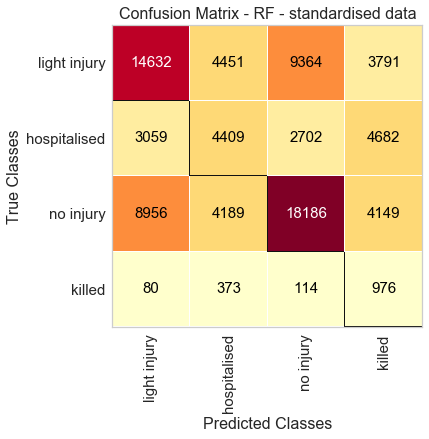

In [225]:
#plotting confusion matrix
plt.figure()
plt.title("Confusion Matrix - RF - standardised data", fontsize=16)
plt.xlabel("Predicted Classes", fontsize=16)
plt.ylabel("True Classes", fontsize=16)
cm = ConfusionMatrix(classifier_rf, classes=["light injury","hospitalised","no injury", "killed"], size=(400,400),
fontsize=15)
cm.fit(trainX, y_train)
cm.score(testX, y_test)

In [250]:
#Plotting classification report
clf_report_rf = classification_report(y_test,
                                   y_pred_rf,
                                   target_names=list(factor[1]),
                                   output_dict=True)

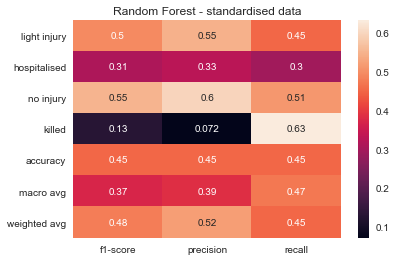

In [269]:
ax=sns.heatmap(pd.DataFrame(clf_report_rf).iloc[:-1, :].T, annot=True)
plt.title ("Random Forest - standardised data")
plt.show()

In [325]:
#computing Matthews correlation coefficient
matthews_corrcoef(y_test, y_pred_rf)

0.21928417034410055

## 1.2 SVM

### Finding the best SVM with randomised grid search

In [ ]:
kernel=['linear', 'sigmoid', 'poly']

class_weight=['balanced']
hyper=dict(kernel=kernel,class_weight=class_weight)
svm=SVC()
rsvm=RandomizedSearchCV(svm, hyper,  random_state=1, n_jobs=-1, cv=5)
#Fit the model
best_model = rsvm.fit(trainX, y_train)
#Print The value of best Hyperparameters
print('Best kernel:', best_model.best_estimator_.get_params()['kernel'])

The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.


### Training Polynomial SVM

In [247]:
#training the best model
svm_model_poly = SVC(kernel = 'poly', C = 1, class_weight='balanced', random_state=1).fit(trainX, y_train) 
y_pred_svm_poly = svm_model_poly.predict(testX) 

### Evaluating Polynomial SVM Model

In [16]:
#showing classification report
print(metrics.classification_report(y_test, y_pred_svm_poly))

              precision    recall  f1-score   support

           0       0.55      0.44      0.49     32238
           1       0.31      0.27      0.29     14852
           2       0.59      0.52      0.55     35480
           3       0.07      0.66      0.13      1543

    accuracy                           0.45     84113
   macro avg       0.38      0.47      0.36     84113
weighted avg       0.51      0.45      0.47     84113



0.44688692592108237

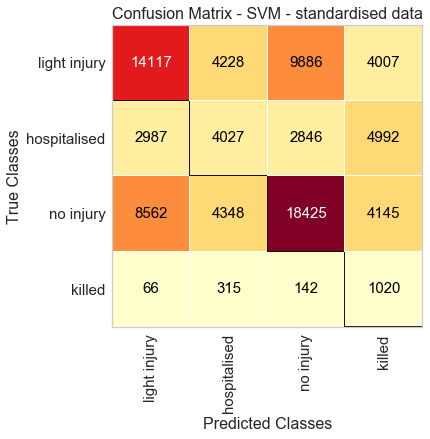

In [271]:
#plotting confusion matrix
plt.figure()
plt.title("Confusion Matrix - SVM - standardised data", fontsize=16)
plt.xlabel("Predicted Classes", fontsize=16)
plt.ylabel("True Classes", fontsize=16)
cm = ConfusionMatrix(svm_model_poly,is_fitted="auto", classes=list(factor[1]), size=(400,400),
fontsize=15)
cm.fit(trainX, y_train)
cm.score(testX, y_test)

In [272]:
#plotting classification report
clf_report_svm = classification_report(y_test,
                                   y_pred_svm_poly,
                                   target_names=list(factor[1]),
                                   output_dict=True)

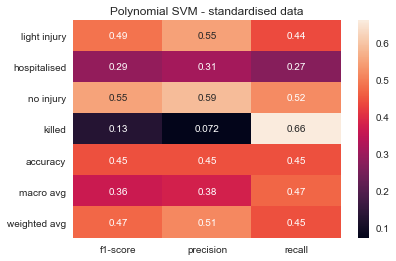

In [273]:
ax=sns.heatmap(pd.DataFrame(clf_report_svm).iloc[:-1, :].T, annot=True)
plt.title ("Polynomial SVM - standardised data")
plt.show()

In [326]:
#Calculating Matthews Correlation Coefficient
matthews_corrcoef(y_test, y_pred_svm_poly)

0.2098627060064911

## 1.3 KNN

### KNN Hyperparameters Tuning

In [20]:
#List Hyperparameters that we want to tune
n_neighbors = list(range(5,10))
p=[1,2]
weights=['distance', 'uniform']
n_jobs=[-1]
#Convert to dictionary
hyperparameters = dict(n_neighbors=n_neighbors, p=p, n_jobs=n_jobs, weights=weights)
#Create new KNN object
knn2 = KNeighborsClassifier()
#Use GridSearch
clf = RandomizedSearchCV(knn2, hyperparameters, cv=10)
#Fit the model
best_model = clf.fit(trainX, y_train)
#Print The value of best Hyperparameters
print('Best p:', best_model.best_estimator_.get_params()['p'])
print('Best n_neighbors:', best_model.best_estimator_.get_params()['n_neighbors'])
print('Best weights:', best_model.best_estimator_.get_params()['weights'])

Best p: 2
Best n_neighbors: 9
Best weights: uniform


In [164]:
#training the best KNN model
knn = KNeighborsClassifier(n_neighbors = 9, p=2, weights="uniform").fit(trainX, y_train) 

### Evaluating KNN model

In [165]:
#calculating predictions
y_pred_knn=knn.predict(testX)

In [166]:
#showing classification report
print(metrics.classification_report(y_test, y_pred_knn))

              precision    recall  f1-score   support

           0       0.46      0.53      0.49     32238
           1       0.36      0.25      0.30     14852
           2       0.53      0.53      0.53     35480
           3       0.19      0.01      0.02      1543

    accuracy                           0.47     84113
   macro avg       0.38      0.33      0.34     84113
weighted avg       0.46      0.47      0.47     84113



From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


0.47452831310261195

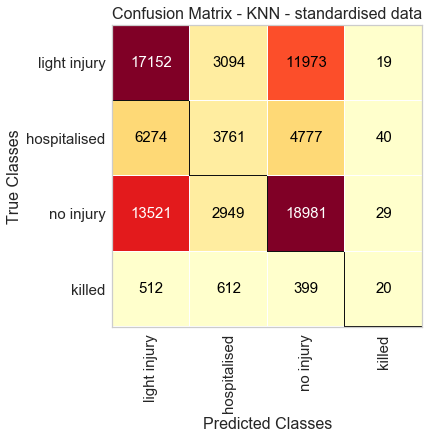

In [227]:
#plotting confusion matrix
plt.figure()
plt.title("Confusion Matrix - KNN - standardised data", fontsize=16)
plt.xlabel("Predicted Classes", fontsize=16)
plt.ylabel("True Classes", fontsize=16)
cm_knn = ConfusionMatrix(knn, classes=list(factor[1]), size=(400,400),
fontsize=15)
cm_knn.fit(trainX, y_train)
cm_knn.score(testX, y_test)

In [274]:
#plotting classification report
clf_report_knn = classification_report(y_test,
                                   y_pred_knn,
                                   target_names=list(factor[1]),
                                   output_dict=True)

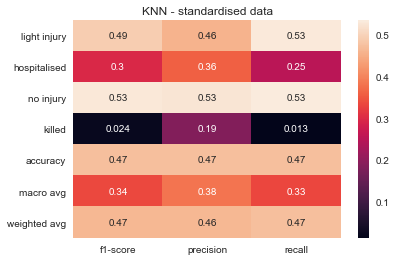

In [275]:
ax=sns.heatmap(pd.DataFrame(clf_report_knn).iloc[:-1, :].T, annot=True)
plt.title ("KNN - standardised data")
plt.show()

In [327]:
#calculating Matthews Correlation Coefficient
matthews_corrcoef(y_test, y_pred_knn)

0.16190193472205844

## 1.4 XGBoost

In [260]:
#setting parameters
param = {
    'learning_rate':0.05,
    'max_depth': 5,  # the maximum depth of each tree
    'eta': 0.3,  # the training step for each iteration
    'silent': 1,  # logging mode - quiet
    'objective': 'multi:softmax',  # error evaluation for multiclass training
    'num_class': 4,
 'n_estimators':1000,
 'min_child_weight':1, # as high class imbalance
 'gamma':0,
 'subsample':0.8,
 'colsample_bytree':0.8}
param['eval_metric']="mlogloss"

xgb1=XGBClassifier(**param)

In [262]:
#fitting the model
xgb1.fit(trainX, y_train)

XGBClassifier(colsample_bytree=0.8, eta=0.3, eval_metric='mlogloss',
              learning_rate=0.05, max_depth=5, n_estimators=1000, num_class=4,
              objective='multi:softprob', silent=1, subsample=0.8)

In [263]:
#computing predictions
y_pred_bst=xgb1.predict(testX)

### Evaluating XGBoost Model

In [264]:
#showing classification report
print(metrics.classification_report(y_test, y_pred_bst))

              precision    recall  f1-score   support

           0       0.53      0.49      0.51     32238
           1       0.40      0.31      0.35     14852
           2       0.54      0.66      0.59     35480
           3       0.24      0.01      0.02      1543

    accuracy                           0.52     84113
   macro avg       0.43      0.37      0.37     84113
weighted avg       0.51      0.52      0.51     84113



In [266]:
#plotting classification report
clf_report = classification_report(y_test,
                                   y_pred_bst,
                                   target_names=list(factor[1]),
                                   output_dict=True)

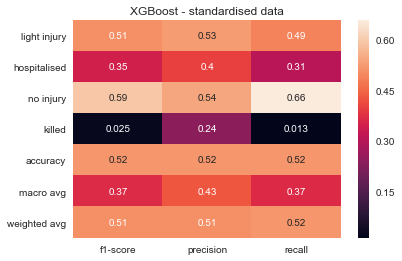

In [267]:
ax=sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True)
plt.title ("XGBoost - standardised data")
plt.show()

From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


0.5186594224436175

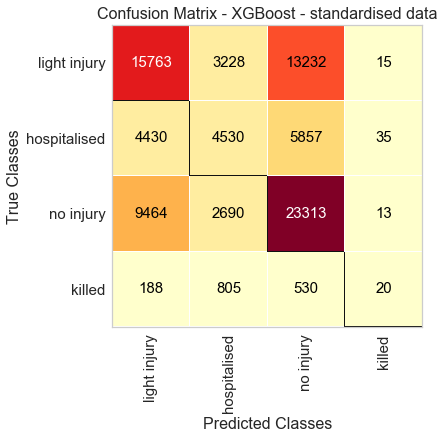

In [268]:
#plotting confusion matrix
plt.figure()
plt.title("Confusion Matrix - XGBoost - standardised data", fontsize=16)
plt.xlabel("Predicted Classes", fontsize=16)
plt.ylabel("True Classes", fontsize=16)
cm_xg = ConfusionMatrix(xgb1, classes=list(factor[1]), size=(400,400),
fontsize=15)
cm_xg.fit(trainX, y_train)
cm_xg.score(testX, y_test)

In [328]:
#Calculating Matthews Correlation Coefficient
matthews_corrcoef(y_test, y_pred_bst)

0.23211740064450484

# 2. Models with normalisation

In [186]:
# prepare input data with normalisation of numerical features
def prepare_inputs(df, X_train, X_test): 
    continuous = list(df.select_dtypes(include='number').columns) 
    categorical = list(df.select_dtypes(include='object').columns)
    # normalising continuous variables
    cs = MinMaxScaler()
    trainContinuous = cs.fit_transform(X_train[continuous])
    testContinuous = cs.transform(X_test[continuous])
    #one-hot encoding for categorical features
    Binarizer= OneHotEncoder(sparse=False).fit(df[categorical])
    trainCategorical = Binarizer.transform(X_train[categorical])
    testCategorical = Binarizer.transform(X_test[categorical])
    
    # construct our training and testing data points by concatenating
    # the categorical features with the continuous features
    trainX = np.hstack([trainCategorical,trainContinuous])
    testX = np.hstack([testCategorical,testContinuous])
    # return the concatenated training and testing data
    return (trainX, testX)

## 2.1 Random Forest

In [187]:
# prepare input data
trainXnorm, testXnorm= prepare_inputs(df_X, X_train, X_test)

In [338]:
#fitting RF model
classifier_rfn = RandomForestClassifier(max_features="sqrt", n_estimators = 400, min_samples_leaf=40, n_jobs=-1, 
                                    max_depth=15, criterion = 'entropy', random_state = 1,class_weight='balanced', bootstrap=True )
classifier_rfn.fit(trainXnorm, y_train)

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=15, max_features='sqrt', min_samples_leaf=40,
                       n_estimators=400, n_jobs=-1, random_state=1)

In [339]:
#computing predictions
y_pred_rf_norm=classifier_rfn.predict(testXnorm)

### Evaluating RF model

In [340]:
#showing classification report
print(metrics.classification_report(y_test, y_pred_rf_norm))

              precision    recall  f1-score   support

           0       0.55      0.45      0.50     32238
           1       0.33      0.30      0.31     14852
           2       0.60      0.51      0.55     35480
           3       0.07      0.63      0.13      1543

    accuracy                           0.45     84113
   macro avg       0.39      0.47      0.37     84113
weighted avg       0.52      0.45      0.48     84113



From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


0.4541866298907422

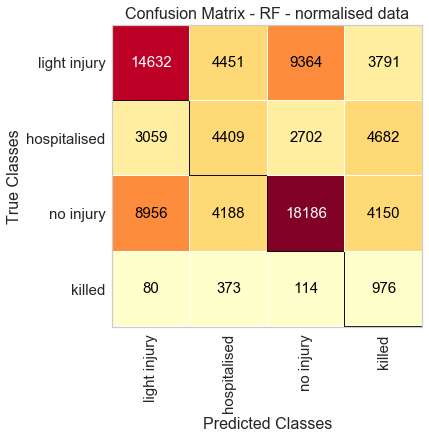

In [341]:
#plotting confusion matrix
plt.figure()
plt.title("Confusion Matrix - RF - normalised data", fontsize=16)
plt.xlabel("Predicted Classes", fontsize=16)
plt.ylabel("True Classes", fontsize=16)
cm_rfn = ConfusionMatrix(classifier_rfn, classes=list(factor[1]), size=(400,400),
fontsize=15)
cm_rfn.fit(trainXnorm, y_train)
cm_rfn.score(testXnorm, y_test)

In [281]:
#plotting classification report
clf_report_rfn = classification_report(y_test,
                                   y_pred_rf_norm,
                                   target_names=list(factor[1]),
                                   output_dict=True)

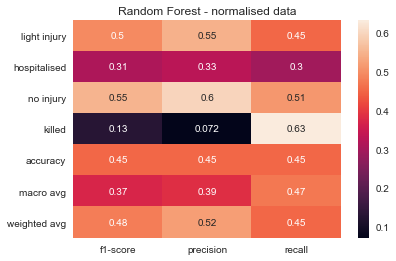

In [282]:
ax=sns.heatmap(pd.DataFrame(clf_report_rfn).iloc[:-1, :].T, annot=True)
plt.title ("Random Forest - normalised data")
plt.show()

In [329]:
#computing Mattheww Correlation Coefficient
matthews_corrcoef(y_test, y_pred_rf_norm)

0.2192869468385143

## 2.2 Polynomial SVM

In [248]:
#fitting the SVM model
svm_model_poly_norm = SVC(kernel = 'poly', C = 1, class_weight='balanced', random_state=1).fit(trainXnorm, y_train) 
y_pred_svm_poly_norm = svm_model_poly_norm.predict(testXnorm) 

### Evaluating SVM Model

From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


0.44282096703244445

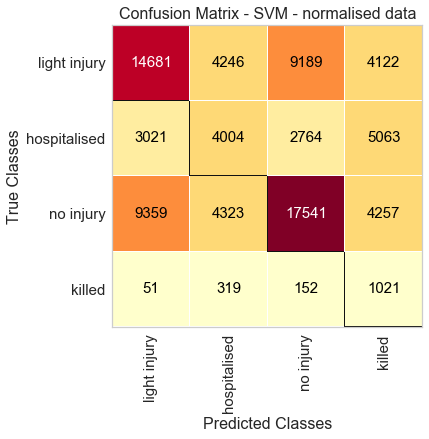

In [283]:
#plotting confusion matrix
plt.figure()
plt.title("Confusion Matrix - SVM - normalised data", fontsize=16)
plt.xlabel("Predicted Classes", fontsize=16)
plt.ylabel("True Classes", fontsize=16)
cm_svmn = ConfusionMatrix(svm_model_poly_norm,is_fitted="auto", classes=list(factor[1]), size=(400,400),
fontsize=15)
cm_svmn.fit(trainXnorm, y_train)
cm_svmn.score(testXnorm, y_test)

In [284]:
#plotting classification report
clf_report_svmn = classification_report(y_test,
                                   y_pred_svm_poly_norm,
                                   target_names=list(factor[1]),
                                   output_dict=True)

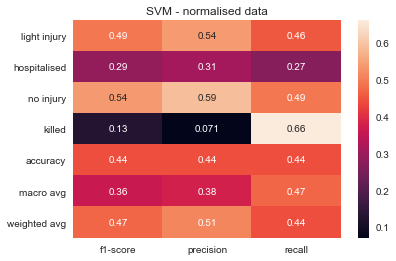

In [285]:
ax=sns.heatmap(pd.DataFrame(clf_report_svmn).iloc[:-1, :].T, annot=True)
plt.title ("SVM - normalised data")
plt.show()

In [ ]:
#showing classification report
print(metrics.classification_report(y_test, y_pred_svm_poly_norm))

In [330]:
#calculating Matthews Correlation Coefficient
matthews_corrcoef(y_test, y_pred_svm_poly_norm)

0.2064003091874451

## 2.3 KNN

In [192]:
#fitting KNN model
knn_n = KNeighborsClassifier(n_neighbors = 9, p=2, weights="uniform").fit(trainXnorm, y_train) 

In [193]:
#computing predictions
y_pred_knn_norm=knn_n.predict(testXnorm)

### Evaluating KNN model

In [194]:
#showing classification report
print(metrics.classification_report(y_test, y_pred_knn_norm))

              precision    recall  f1-score   support

           0       0.46      0.52      0.49     32238
           1       0.36      0.25      0.30     14852
           2       0.53      0.55      0.54     35480
           3       0.17      0.01      0.02      1543

    accuracy                           0.48     84113
   macro avg       0.38      0.33      0.34     84113
weighted avg       0.46      0.48      0.47     84113



From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


0.4757409675079952

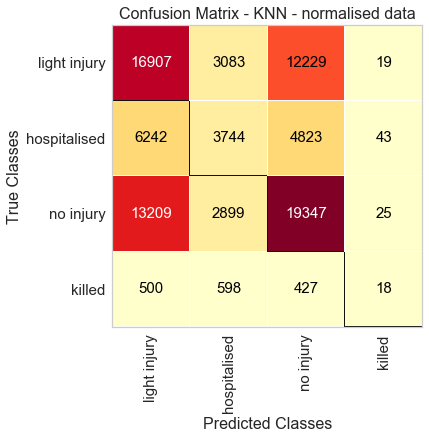

In [286]:
#plotting confusion matrix
plt.figure()
plt.title("Confusion Matrix - KNN - normalised data", fontsize=16)
plt.xlabel("Predicted Classes", fontsize=16)
plt.ylabel("True Classes", fontsize=16)
cm_knn_n = ConfusionMatrix(knn_n, classes=list(factor[1]), size=(400,400),
fontsize=15)
cm_knn_n.fit(trainXnorm, y_train)
cm_knn_n.score(testXnorm, y_test)

In [287]:
#plotting classification report
clf_report_knn_norm = classification_report(y_test,
                                   y_pred_knn_norm,
                                   target_names=list(factor[1]),
                                   output_dict=True)

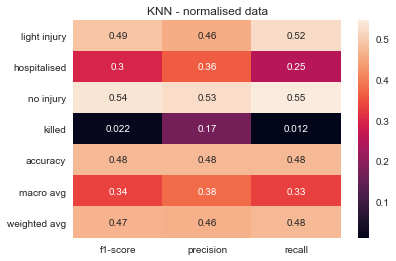

In [288]:
ax=sns.heatmap(pd.DataFrame(clf_report_knn_norm).iloc[:-1, :].T, annot=True)
plt.title ("KNN - normalised data")
plt.show()

In [331]:
#calculating Matthews Correlation Coefficient
matthews_corrcoef(y_test, y_pred_knn_norm)

0.16303423224330066

## 2.4 XGBoost

In [260]:
#setting parameters
param = {
    'learning_rate':0.05,
    'max_depth': 5,  # the maximum depth of each tree
    'eta': 0.3,  # the training step for each iteration
    'silent': 1,  # logging mode - quiet
    'objective': 'multi:softmax',  # error evaluation for multiclass training
    'num_class': 4,
 'n_estimators':1000,
 'min_child_weight':1, # as high class imbalance
 'gamma':0,
 'subsample':0.8,
 'colsample_bytree':0.8}
param['eval_metric']="mlogloss"

xgb_norm=XGBClassifier(**param)

In [290]:
#fitting the XGBoost model
xgb_norm.fit(trainXnorm, y_train)

XGBClassifier(colsample_bytree=0.8, eta=0.3, eval_metric='mlogloss',
              learning_rate=0.05, max_depth=5, n_estimators=1000, num_class=4,
              objective='multi:softprob', silent=1, subsample=0.8)

In [291]:
#calculating predictions
y_pred_bst_norm=xgb_norm.predict(testXnorm)

### Evaluating XGBoost model

In [292]:
#showing classification report
print(metrics.classification_report(y_test, y_pred_bst_norm))

              precision    recall  f1-score   support

           0       0.53      0.49      0.51     32238
           1       0.40      0.30      0.35     14852
           2       0.54      0.66      0.59     35480
           3       0.30      0.02      0.03      1543

    accuracy                           0.52     84113
   macro avg       0.44      0.37      0.37     84113
weighted avg       0.51      0.52      0.51     84113



In [293]:
#plotting classification report
clf_report_xgb_norm = classification_report(y_test,
                                   y_pred_bst_norm,
                                   target_names=list(factor[1]),
                                   output_dict=True)

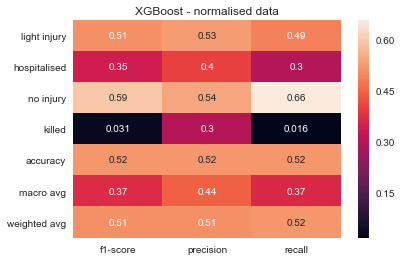

In [294]:
ax=sns.heatmap(pd.DataFrame(clf_report_xgb_norm).iloc[:-1, :].T, annot=True)
plt.title ("XGBoost - normalised data")
plt.show()

From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


0.518160094159048

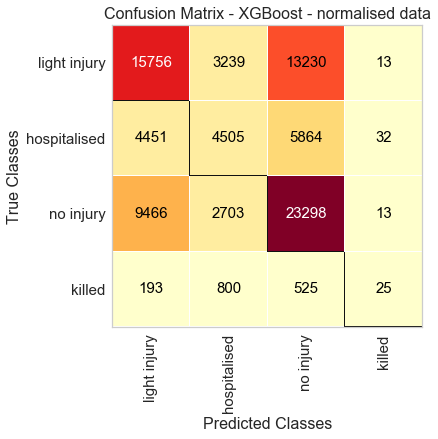

In [295]:
#plotting confusion matrix
plt.figure()
plt.title("Confusion Matrix - XGBoost - normalised data", fontsize=16)
plt.xlabel("Predicted Classes", fontsize=16)
plt.ylabel("True Classes", fontsize=16)
cm_xg = ConfusionMatrix(xgb_norm, classes=list(factor[1]), size=(400,400),
fontsize=15)
cm_xg.fit(trainXnorm, y_train)
cm_xg.score(testXnorm, y_test)

In [332]:
#calculating Matthews Correlation Coefficient
matthews_corrcoef(y_test, y_pred_bst_norm)

0.2312936622777148

# 3. Models - data without scaling

In [205]:
#preparing inputs without scaling
def prepare_inputs(df, X_train, X_test): 
    continuous = list(df.select_dtypes(include='number').columns) 
    categorical = list(df.select_dtypes(include='object').columns)
    
    trainContinuous = X_train[continuous]
    testContinuous = X_test[continuous]
    #one-hot encoding for categorical features
    Binarizer= OneHotEncoder().fit(df[categorical])
    trainCategorical = Binarizer.transform(X_train[categorical])
    testCategorical = Binarizer.transform(X_test[categorical])
    
    # construct our training and testing data points by concatenating
    # the categorical features with the continuous features
    trainX = np.hstack([trainCategorical.toarray(),trainContinuous])
    testX = np.hstack([testCategorical.toarray(),testContinuous])
    # return the concatenated training and testing data
    return (trainX, testX)

## 3.1 Random Forest

In [206]:
# prepare input data
trainXu, testXu= prepare_inputs(df_X, X_train, X_test)

In [342]:
#fitting RF model
classifier_rfu = RandomForestClassifier(max_features="sqrt", n_estimators = 400, min_samples_leaf=40, n_jobs=-1, 
                                    max_depth=15, criterion = 'entropy', random_state = 1,class_weight='balanced', bootstrap=True )
classifier_rfu.fit(trainXu, y_train)

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=15, max_features='sqrt', min_samples_leaf=40,
                       n_estimators=400, n_jobs=-1, random_state=1)

In [343]:
#computing predictions
y_pred_rfu=classifier_rfu.predict(testXu)

### Evaluating RF model

In [345]:
#plotting classification report
clf_report_rfu = classification_report(y_test,
                                   y_pred_rfu,
                                   target_names=list(factor[1]),
                                   output_dict=True)

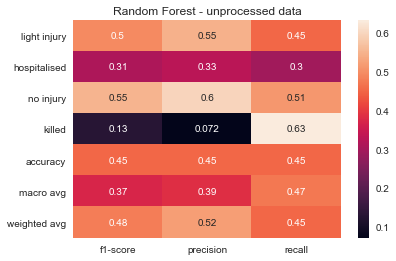

In [346]:
ax=sns.heatmap(pd.DataFrame(clf_report_rfu).iloc[:-1, :].T, annot=True)
plt.title ("Random Forest - unprocessed data")
plt.show()

From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


0.45419851865942246

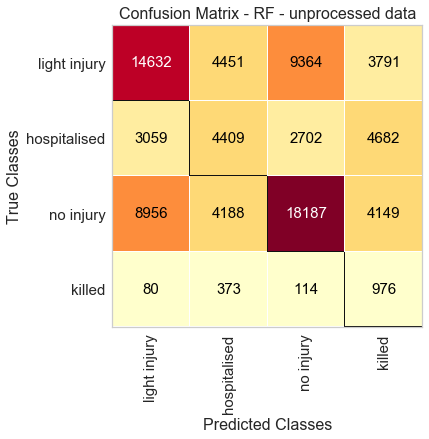

In [347]:
#plotting confusion matrix
plt.figure()
plt.title("Confusion Matrix - RF - unprocessed data", fontsize=16)
plt.xlabel("Predicted Classes", fontsize=16)
plt.ylabel("True Classes", fontsize=16)
cm_rfu = ConfusionMatrix(classifier_rfu, classes=list(factor[1]), size=(400,400),
fontsize=15)
cm_rfu.fit(trainXu, y_train)
cm_rfu.score(testXu, y_test)

In [210]:
#showing classification report
print(metrics.classification_report(y_test, y_pred_rfu))

              precision    recall  f1-score   support

           0       0.55      0.45      0.50     32238
           1       0.33      0.30      0.31     14852
           2       0.60      0.51      0.55     35480
           3       0.07      0.63      0.13      1543

    accuracy                           0.45     84113
   macro avg       0.39      0.47      0.37     84113
weighted avg       0.52      0.45      0.48     84113



In [333]:
#computing Matthews Correlation Coefficient
matthews_corrcoef(y_test, y_pred_rfu)

0.21929811038686525

## 3.2 Polynomial SVM

In [249]:
#fitting the model
svm_model_poly_u = SVC(kernel = 'poly', C = 1, class_weight='balanced', random_state=1).fit(trainXu, y_train) 
#computing predictions
y_pred_svm_poly_u = svm_model_poly_u.predict(testXu) 

### Evaluating SVM Model

From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


0.4072616599098831

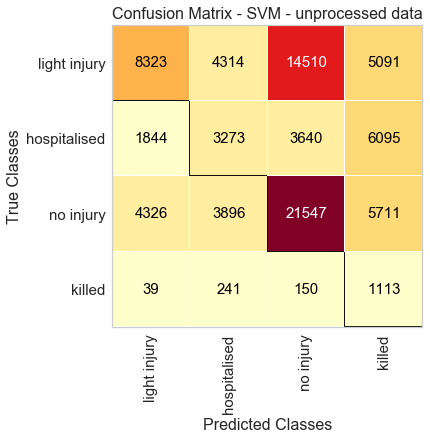

In [302]:
#plotting confusion matrix
plt.figure()
plt.title("Confusion Matrix - SVM - unprocessed data", fontsize=16)
plt.xlabel("Predicted Classes", fontsize=16)
plt.ylabel("True Classes", fontsize=16)
cm_svmu = ConfusionMatrix(svm_model_poly_u,is_fitted="auto", classes=list(factor[1]), size=(400,400),
fontsize=15)
cm_svmu.fit(trainXu, y_train)
cm_svmu.score(testXu, y_test)

In [303]:
#plotting classification report
clf_report_svmu = classification_report(y_test,
                                   y_pred_svm_poly_u,
                                   target_names=list(factor[1]),
                                   output_dict=True)

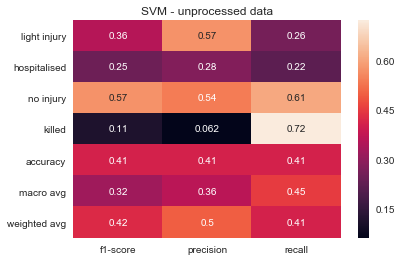

In [304]:
ax=sns.heatmap(pd.DataFrame(clf_report_svmu).iloc[:-1, :].T, annot=True)
plt.title ("SVM - unprocessed data")
plt.show()

In [79]:
#showing classification report
print(metrics.classification_report(y_test, y_pred_svm_poly_u))

              precision    recall  f1-score   support

           0       0.57      0.26      0.36     32238
           1       0.28      0.22      0.25     14852
           2       0.54      0.61      0.57     35480
           3       0.06      0.72      0.11      1543

    accuracy                           0.41     84113
   macro avg       0.36      0.45      0.32     84113
weighted avg       0.50      0.41      0.42     84113



In [334]:
#calculating Matthews Correlation Coefficient
matthews_corrcoef(y_test, y_pred_svm_poly_u)

0.17026104666635195

## 3.3 KNN

In [212]:
#fitting KNN model
knn_u = KNeighborsClassifier(n_neighbors = 9, p=2, weights="uniform").fit(trainXu, y_train) 

In [213]:
#computing predictions
y_pred_knnu=knn_u.predict(testXu)

### Evaluating KNN model

In [214]:
#showing classification report
print(metrics.classification_report(y_test, y_pred_knnu))

              precision    recall  f1-score   support

           0       0.46      0.51      0.48     32238
           1       0.37      0.25      0.30     14852
           2       0.52      0.55      0.53     35480
           3       0.22      0.01      0.03      1543

    accuracy                           0.47     84113
   macro avg       0.39      0.33      0.34     84113
weighted avg       0.46      0.47      0.46     84113



From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


0.4726974427258569

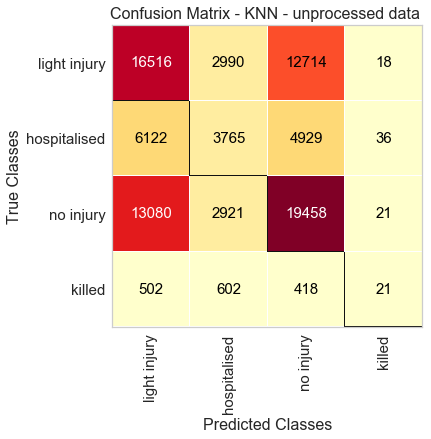

In [305]:
#plotting confusion matrix
plt.figure()
plt.title("Confusion Matrix - KNN - unprocessed data ", fontsize=16)
plt.xlabel("Predicted Classes", fontsize=16)
plt.ylabel("True Classes", fontsize=16)
cm_knnu = ConfusionMatrix(knn_u, classes=list(factor[1]), size=(400,400),
fontsize=15)
cm_knnu.fit(trainXu, y_train)
cm_knnu.score(testXu, y_test)

In [306]:
#plotting classification report
clf_report_knnu = classification_report(y_test,
                                   y_pred_knnu,
                                   target_names=list(factor[1]),
                                   output_dict=True)

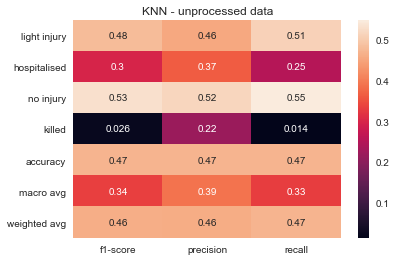

In [307]:
ax=sns.heatmap(pd.DataFrame(clf_report_knnu).iloc[:-1, :].T, annot=True)
plt.title ("KNN - unprocessed data")
plt.show()

In [335]:
#calculating Matthews Correlation Coefficient
matthews_corrcoef(y_test, y_pred_knnu)

0.1574599321519635

## 3.4 XGBoost

In [218]:
#setting parameters
param = {
    'learning_rate':0.05,
    'max_depth': 5,  # the maximum depth of each tree
    'eta': 0.3,  # the training step for each iteration
    'silent': 1,  # logging mode - quiet
    'objective': 'multi:softmax',  # error evaluation for multiclass training
    'num_class': 4,
 'n_estimators':1000,
 'min_child_weight':1, # as high class imbalance
 'gamma':0,
 'subsample':0.8,
 'colsample_bytree':0.8}  # the number of classes that exist in this datset
num_round = 20  # the number of training iterations
xgbu=XGBClassifier(**param)


In [309]:
#fitting the model
xgbu.fit(trainXu, y_train)

XGBClassifier(colsample_bytree=0.8, eta=0.3, eval_metric='mlogloss',
              learning_rate=0.05, max_depth=5, n_estimators=1000, num_class=4,
              objective='multi:softprob', silent=1, subsample=0.8)

In [310]:
#computing predictions
y_pred_bstu=xgbu.predict(testXu)

### Evaluating XGBoost model

In [311]:
#showing classification report
print(metrics.classification_report(y_test, y_pred_bstu))

              precision    recall  f1-score   support

           0       0.53      0.49      0.51     32238
           1       0.40      0.31      0.35     14852
           2       0.54      0.66      0.59     35480
           3       0.28      0.02      0.03      1543

    accuracy                           0.52     84113
   macro avg       0.44      0.37      0.37     84113
weighted avg       0.51      0.52      0.51     84113



In [312]:
#visualising classification report
clf_report_xgbu = classification_report(y_test,
                                   y_pred_bstu,
                                   target_names=list(factor[1]),
                                   output_dict=True)

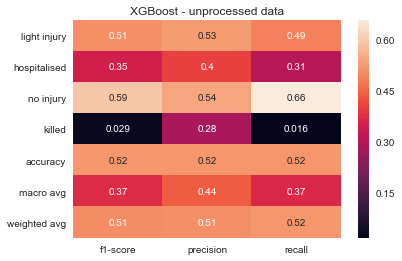

In [313]:
ax=sns.heatmap(pd.DataFrame(clf_report_xgbu).iloc[:-1, :].T, annot=True)
plt.title ("XGBoost - unprocessed data")
plt.show()

From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


0.5183503144579316

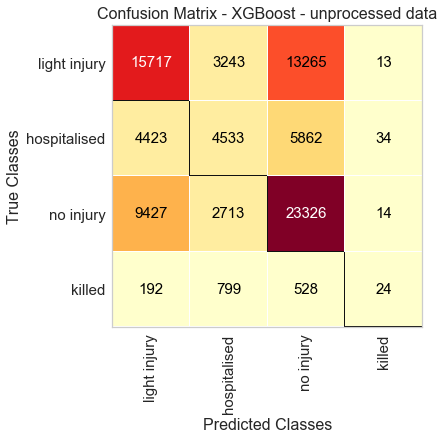

In [314]:
#visualising confusion matrix
plt.figure()
plt.title("Confusion Matrix - XGBoost - unprocessed data", fontsize=16)
plt.xlabel("Predicted Classes", fontsize=16)
plt.ylabel("True Classes", fontsize=16)
cm_xg = ConfusionMatrix(xgbu, classes=list(factor[1]), size=(400,400),
fontsize=15)
cm_xg.fit(trainXu, y_train)
cm_xg.score(testXu, y_test)

In [336]:
#calculating Matthews Correlation Coefficient
matthews_corrcoef(y_test, y_pred_bstu)

0.23173136580629425